# Brownian motion model in parallel
This notebook simulates the Brownian motion of multiple agents in a 2D space using parallel processing. The Agent class represents an agent that moves randomly in the x and y directions. The experiment function simulates the movement of a specified number of agents over a given number of moves. The multiprocessing.Pool is used to run multiple experiments in parallel

There is also a version where ecach process writes its results to a shared file, A Manager function from the multiprocessing module is used to handle the shared file.  
.  
See full code explanation below

In [4]:
#! pip install --upgrade pip

In [5]:
from random import randint
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager,cpu_count
from filelock import FileLock

In [6]:
# Define the Agent class to represent an agent in a 2D space
class Agent:
    def __init__(self, x=0, y=0):
        # Initialize the agent's position
        self.x = x
        self.y = y

    def move(self):
        # Move the agent by adding a random integer between -1 and 1 to both x and y
        self.x += randint(-1, 1)
        self.y += randint(-1, 1)

    def __str__(self):
        # Return a string representation of the agent's position
        return f"Agent at position ({self.x}, {self.y})"


In [7]:
# Define the experiment function to simulate the movement of agents
def experiment(task):
    # Unpack the task tuple
    task_id, num_agents, num_moves = task
    # Create a list of agents
    agents = [Agent() for _ in range(num_agents)]
    # Simulate the movement of agents
    for _ in range(num_moves):
        for a in agents:
            a.move()
    # Print a message indicating that the task is done
    print(f'Task {task_id} done')
    # Return the final positions of all agents
    return [(a.x, a.y) for a in agents]

Using 8 cores
Starting ....
Task 4 done
Task 7 done
Task 6 done
Task 5 done
Task 1 done
Task 3 done
Task 2 done
Task 0 done
Task 8 done
Task 9 done
Task 10 done
Task 11 done
Done


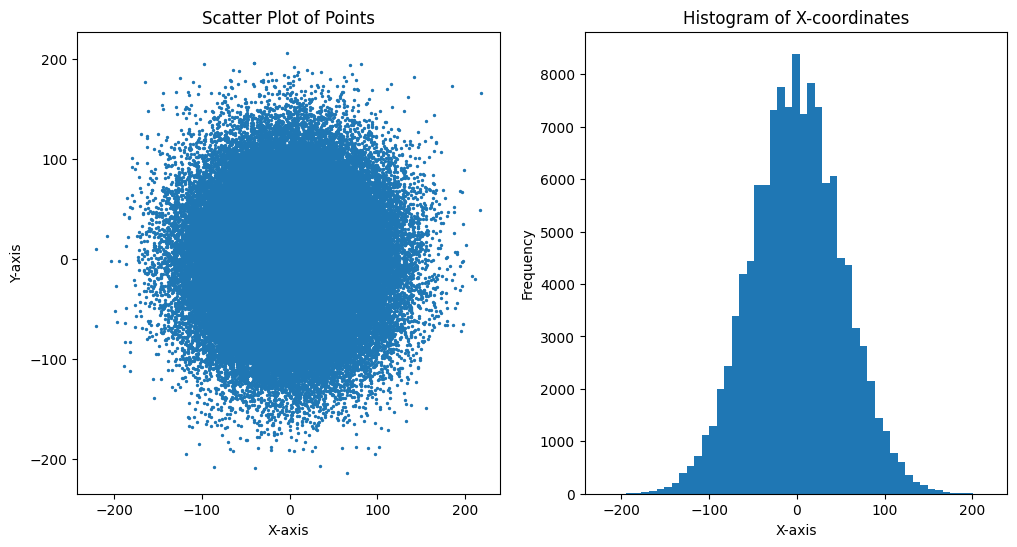

In [ ]:
# Define the number of tasks
num_tasks = 12
# Create a list of tasks, each task is a tuple containing task_id, num_agents, and num_moves
num_agents = 10000
iterations = 10000
tasks = [
    (id, num_agents, iterations)  # Note passed as tuples Important
    for id in range(num_tasks)
]

# print out the number of avalable cores
print(f"Using {cpu_count()} cores")

# Use Pool to manage parallel execution
with Pool() as pool:
    # Map the experiment function to the list of tasks and collect the results
    print("Starting ....")
    results = pool.map(experiment, tasks)
    print("Done")

    # Initialize an empty list to store all points
    points = []
    # Extend the points list with the results from each task
    for result in results:
        points.extend(result)



# Unpack the points into x_coords and y_coords
x_coords, y_coords = zip(*points)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot
axs[0].scatter(x_coords, y_coords, s=2 )
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Scatter Plot of Points')

# Histogram
axs[1].hist(x_coords, bins=51)
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of X-coordinates')

plt.show()




### Task Definition and Parallel Execution

#### Task Definition
```python
num_tasks = 8
num_agents = 1000
iterations = 4000
tasks = [
    (id, num_agents, iterations)  # Note passed as tuples Important
    for id in range(num_tasks)
]
```
- `num_tasks` is set to 8, indicating that there will be 8 parallel tasks.
- `tasks` is a list of tuples. Each tuple contains three elements:
  - `task_id`: A unique identifier for the task (ranging from 0 to 7).
  - `num_agents`: The number of agents to simulate in this task (1000).
  - `num_moves`: The number of moves each agent will make (4000).

The list comprehension generates 8 tuples, each representing a different task.

#### Parallel Execution with `Pool`

```python
with Pool() as pool:
    results = pool.map(experiment, tasks)
    points = []
    for result in results:
        points.extend(result)

x_coords, y_coords = zip(*points)
```
- `Pool()` creates a pool of worker processes. The `with` statement ensures that the pool is properly managed and cleaned up after use.
- `pool.map(experiment, tasks)` applies the `experiment` function to each task in the `tasks` list in parallel. Here's how it works:
  - The `experiment` function is defined to take a single task tuple as an argument.
  - `pool.map` distributes these tasks across multiple worker processes.
  - Each worker process runs the `experiment` function on its assigned task.
  - The results from each task are collected and returned as a list.

#### Detailed Explanation of `pool.map`

1. **Task Distribution**:
   - The `pool.map` function distributes the tasks across the available worker processes. If you have 8 tasks and 8 worker processes, each process will handle one task.
   - If you have more tasks than worker processes, the tasks will be distributed in a round-robin fashion.

2. **Parallel Execution**:
   - Each worker process runs the `experiment` function independently. This means that the simulation of agent movements for each task is performed concurrently.
   - The `experiment` function simulates the movement of 1000 agents for 4000 moves, which is a computationally intensive task. By running these simulations in parallel, the overall execution time is significantly reduced compared to running them sequentially.

3. **Result Collection**:
   - The results from each task are collected into the `results` list. Each element in `results` is a list of tuples representing the final positions of the agents in that task.
   - The `points` list is then populated by extending it with the results from each task.

#### Extracting Coordinates

```python
x_coords, y_coords = zip(*points)
```
- `zip(*points)` unpacks the `points` list and groups the x-coordinates and y-coordinates separately.
- `x_coords` will contain all the x-coordinates of the final positions.
- `y_coords` will contain all the y-coordinates of the final positions.

### How Python Handles Parallelism

Python's `multiprocessing` module allows you to create processes that run in parallel. Here's a brief overview of how it works:

1. **Process Creation**:
   - When you create a `Pool`, it spawns a number of worker processes. By default, the number of worker processes is equal to the number of CPU cores on your machine.

2. **Inter-Process Communication (IPC)**:
   - The `Pool` manages communication between the main process and the worker processes. When you call `pool.map`, the tasks are sent to the worker processes, and the results are collected back in the main process.

3. **Data Sharing**:
   - Each worker process has its own memory space, so data is not shared directly between processes.

4. **Synchronization**:
   - The `Pool` handles synchronization between the main process and the worker processes. It ensures that tasks are distributed and results are collected in a controlled manner.



## An example that writes  results to file

To modify the code to use a generator for the task list and write each result to a shared file as it is completed, you can follow these steps:

Use a generator to yield tasks.  
Write results to a shared file within the experiment function.  
Use a Manager from the multiprocessing module to handle the shared file.  
Here's the modified code:  


Using 8 cores
Starting ...
Writing task 4 data
Task 4 done
Writing task 3 data
Task 3 done
Writing task 7 data
Task 7 done
Writing task 5 data
Task 5 done
Writing task 0 data
Task 0 done
Writing task 6 data
Task 6 done
Writing task 1 data
Task 1 done
Writing task 2 data
Task 2 done
Writing task 9 data
Task 9 done
Writing task 8 data
Task 8 done
Writing task 13 data
Task 13 done
Writing task 10 data
Task 10 done
Writing task 12 data
Task 12 done
Writing task 11 data
Task 11 done
Writing task 14 data
Task 14 done
Writing task 15 data
Task 15 done
Done


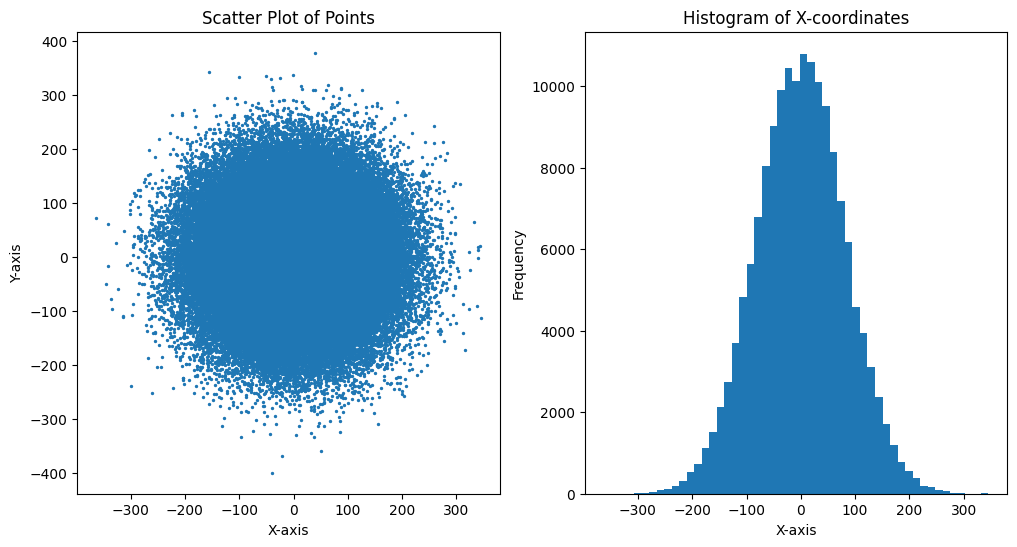

In [10]:
# Define the experiment function
def experiment(task):
    task_id, num_agents, num_moves, shared_file = task
    # Unpack the task tuple
    task_id, num_agents, num_moves = task_id, num_agents, num_moves

    # Create a list of agents
    agents = [Agent() for _ in range(num_agents)]

    # Simulate the movement of agents
    for _ in range(num_moves):
        for a in agents:
            a.move()



    # Collect the results (positions of agents)
    result = [(a.x, a.y) for a in agents]

    # Create a file lock to ensure thread-safe file writing
    lock = FileLock(shared_file + '.lock')
    print(f'Writing task {task_id} data')
    # Acquire the lock and write the results to the shared file
    with lock:
        with open(shared_file, 'a') as f:
            for point in result:
                f.write(f"{point[0]} {point[1]}\n")

    # Print a message indicating the task is done
    print(f'Task {task_id} done')
    # Return the result for further processing
    #return result

# Define a generator for tasks
def task_generator(num_tasks, shared_file):
    for i in range(num_tasks):
        yield (i, 10000, 10000, shared_file)

# Define the number of tasks and the shared file name
num_tasks = 16
shared_file = 'results.txt'

# Ensure the shared file is empty before starting
open(shared_file, 'w').close()

# Print out the number of available cores
print(f"Using {cpu_count()} cores")

# Use Pool to manage parallel execution
with Pool() as pool:
    # Use imap to process tasks as they are generated
    print("Starting ...")
    results = pool.imap(experiment, task_generator(num_tasks, shared_file))


    # Process each result as it comes in
    for result in results:
        pass  # You can process each result here if needed
print("Done")
# Ensure all processes have completed before reading the file
pool.close()
pool.join()

# Initialize an empty list to store all points
points = []

# Read the results from the shared file
with open(shared_file, 'r') as f:
    for line in f:
        x, y = map(int, line.split())
        points.append((x, y))

# Unzip the points into separate lists for x and y coordinates
x_coords, y_coords = zip(*points)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot
axs[0].scatter(x_coords, y_coords, s=2)
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Scatter Plot of Points')

# Histogram
axs[1].hist(x_coords, bins=51)
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of X-coordinates')

plt.show()




### Imports and Setup

```python
from multiprocessing import Pool
from filelock import FileLock
import matplotlib.pyplot as plt
```


- **filelock.FileLock**: This library is used to create a file lock to ensure that file operations are thread-safe.


### Experiment Function

```python
def experiment(task, shared_file):
    task_id, num_agents, num_moves = task
    agents = [Agent() for _ in range(num_agents)]
    for _ in range(num_moves):
        for a in agents:
            a.move()
    print(f'{task_id} done')
    result = [(a.x, a.y) for a in agents]

    lock = FileLock(shared_file + '.lock')
    with lock:
        with open(shared_file, 'a') as f:
            for point in result:
                f.write(f"{point[0]} {point[1]}\n")

    return result
```

- **task**: A tuple containing `task_id`, `num_agents`, and `num_moves`.
- **shared_file**: The name of the file where results will be written.
- **Unpacking Task**: The task tuple is unpacked into `task_id`, `num_agents`, and `num_moves`.
- **Agent Creation**: A list of `Agent` objects is created. Each `Agent` object represents an agent in the simulation.
- **Agent Movement**: Each agent moves a specified number of times (`num_moves`). The `move` method of the `Agent` class is called for each agent.
- **Result Collection**: The positions of the agents are collected into a list of tuples `(x, y)`.
- **File Locking**: A file lock is created to ensure thread-safe writing to the shared file.
- **Writing Results**: The results are written to the shared file in a thread-safe manner.
- **Returning Results**: The results are returned for further processing.

### Task Generator

```python
def task_generator(num_tasks):
    for i in range(num_tasks):
        yield (i, 1000, 4000)
```

- **num_tasks**: The number of tasks to generate.
- **Yielding Tasks**: The generator yields tasks as tuples containing `task_id`, `num_agents`, and `num_moves`. In this case, `num_agents` is 1000 and `num_moves` is 4000 for each task.

### Main Execution

```python
num_tasks = 8
shared_file = 'results.txt'

# Ensure the shared file is empty before starting
open(shared_file, 'w').close()

with Pool() as pool:
    results = pool.imap(experiment, task_generator(num_tasks, shared_file))

# Ensure all processes have completed before reading the file
pool.close()
pool.join()

points = []
with open(shared_file, 'r') as f:
    for line in f:
        x, y = map(int, line.split())
        points.append((x, y))

x_coords, y_coords = zip(*points)

plt.scatter(x_coords, y_coords, s=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Points')
plt.show()
```
- **Generator Function**: The task_generator function is defined to yield tasks one at a time. This way, the tasks are generated on-the-fly as needed, rather than all at once.
- **num_tasks**: The number of tasks to be processed. In this case, it is set to 8.
- **shared_file**: The name of the file where results will be written.
- **Ensure Shared File is Empty**: The shared file is ensured to be empty before starting by opening it in write mode and immediately closing it.
- **Pool Management**: A `Pool` is created to manage parallel execution of tasks.
- **Mapping Tasks**: The `experiment` function is mapped to the list of tasks using `pool.starmap`. This allows each task to be processed in parallel.
- **Ensuring Completion**: The pool is closed and joined to ensure all processes have completed.
- **Reading Results**: The results are read from the shared file and stored in a list of tuples `(x, y)`.
